# DDP - Value Iteration

In [1]:
import numpy as np
import bisect as bi
from mpl_toolkits import mplot3d
import matplotlib.pyplot as pt

### Helper

In [2]:
def edInt(a,s,b):
    return np.linspace(a,b,int(np.floor((b-a)/s)))

# Used for poorman's nearest-neighbour regular-grid interpolation
def idx(aList, val):
    i = bi.bisect(aList, val) # right
    if i <= 0: # first
        pass
    elif len(aList) == i: # last
        i -= 1
    elif val - aList[i-1] < aList[i] - val: # left
        i -= 1
    return i

def lookup(aList, vals): # inefficient
    """vals is sorted"""
    indices = []
    v = vals
    if type(v) in [int,float,np.float64]:
        v = [v]
    for k in np.sort(v):
        indices.append(idx(aList,k))
    return np.array(indices, dtype=np.uint32)

### Settings 

In [3]:
t0 = 0; dt = .05; tf = 2; infStValInc = 3000; nullCtr = 0
du = 2; dphi = .1 ; dphidot = .05

T = edInt(t0, dt, tf) # time horizon
U = edInt(-50, du, 10) # admissible controls (must be smaller than state space)

Phi, Phidot = np.meshgrid(
    edInt(-2,dphi,2),
    edInt(-5,dphidot,4)
) # admissible states

g = 9.81 # [m/s^2]
l = 3*g/(2*21.5) # [m]
m = 3/(0.6 * l**2) # [kg]

v1 = 3*g/(2*l)
v2 = 3/(m * l**2)

Q = [[300,0],
     [0,300]]

R = 0.05 #Solution
x0 = np.array([.52,0.2]) # initial state
N = T.size
V = np.zeros((Phidot.shape[0], Phi.shape[1], N)) # optimal cost/control arrays

u_opt = V.copy()
V[:,:,N-1] = Q[0][0] * Phi**2 + Q[1][1] * Phidot**2 # terminal state penalties (ensures goal-state penalty = 0)
errPhi = np.zeros((Phidot.shape[0], Phi.shape[1]))
errPhidot = errPhi.copy()
depth=0

### Algorithm  

In [4]:
for k in range(N-1,depth,-1):
    for i in range(0,Phidot.shape[0]-1):
        for j in range(0,Phi.shape[1]-1):
            # Calculate instant cost for each control
            L = Q[0][0] * Phi[i,j]**2 + Q[1][1] * Phidot[i,j]**2 + R * U**2
            
            #Predict next state for each control.
            newPhi = Phi[i,j] + Phidot[i,j]*dt
            newPhidot = Phidot[i,j] + (v1*Phi[i,j] + v2*U) * dt
            
            # New grid index for each state
            i_newPhi = lookup(Phi[0,:],newPhi) # naive interpolation
            i_newPhidot = lookup(Phidot[:,0],newPhidot)
            i_U = range(0,U.size)
            errPhi[i,j] = newPhi # truncated dynamics
            errPhidot[i,j] = max(newPhidot)
            
            # make sure admissible state/control combinations exist
            if (i_newPhi.size != 0 and i_newPhidot.size != 0):
                #bellman equation to find minimal cost controll.
                i_U, V[i,j,k-1] = min(enumerate(L[i_U] + V[i_newPhidot, i_newPhi, k]), key=lambda x : x[1])
            else:
                i_U, V[i,j,k-1] = lookup(U,nullCtr)[0][0], V[i,j,k] + infStValInc
            u_opt[i,j,k-1] = U[i_U] # i_U should be a singleton list

### Simulation (from x0 using u_opt)

In [5]:
x = np.zeros((T.size,2))
x[0,:] = x0
u = np.zeros(T.size)
for k in range(0,T.size-1):
    if not(x[k,0]>=Phi[0,0] and x[k,0]<=Phi[0,-1]
           and x[k,1]>=Phidot[0,0] and x[k,1]<=Phidot[-1,0]): # admissibility check
        print(f'stopped at {k}/{T.size}', x[k,0], x[k,1])
        break
    i_phi = lookup(Phi[0,:],x[k,0])[0]
    i_phidot = lookup(Phidot[:,0],x[k,1])[0]
    u[k] = u_opt[i_phidot, i_phi, k]
    x[k+1,0] = x[k,0] + x[k,1] * dt
    x[k+1,1] = x[k,1] + (v1*x[k,0] + v2*u[k]) * dt

### Visualisation

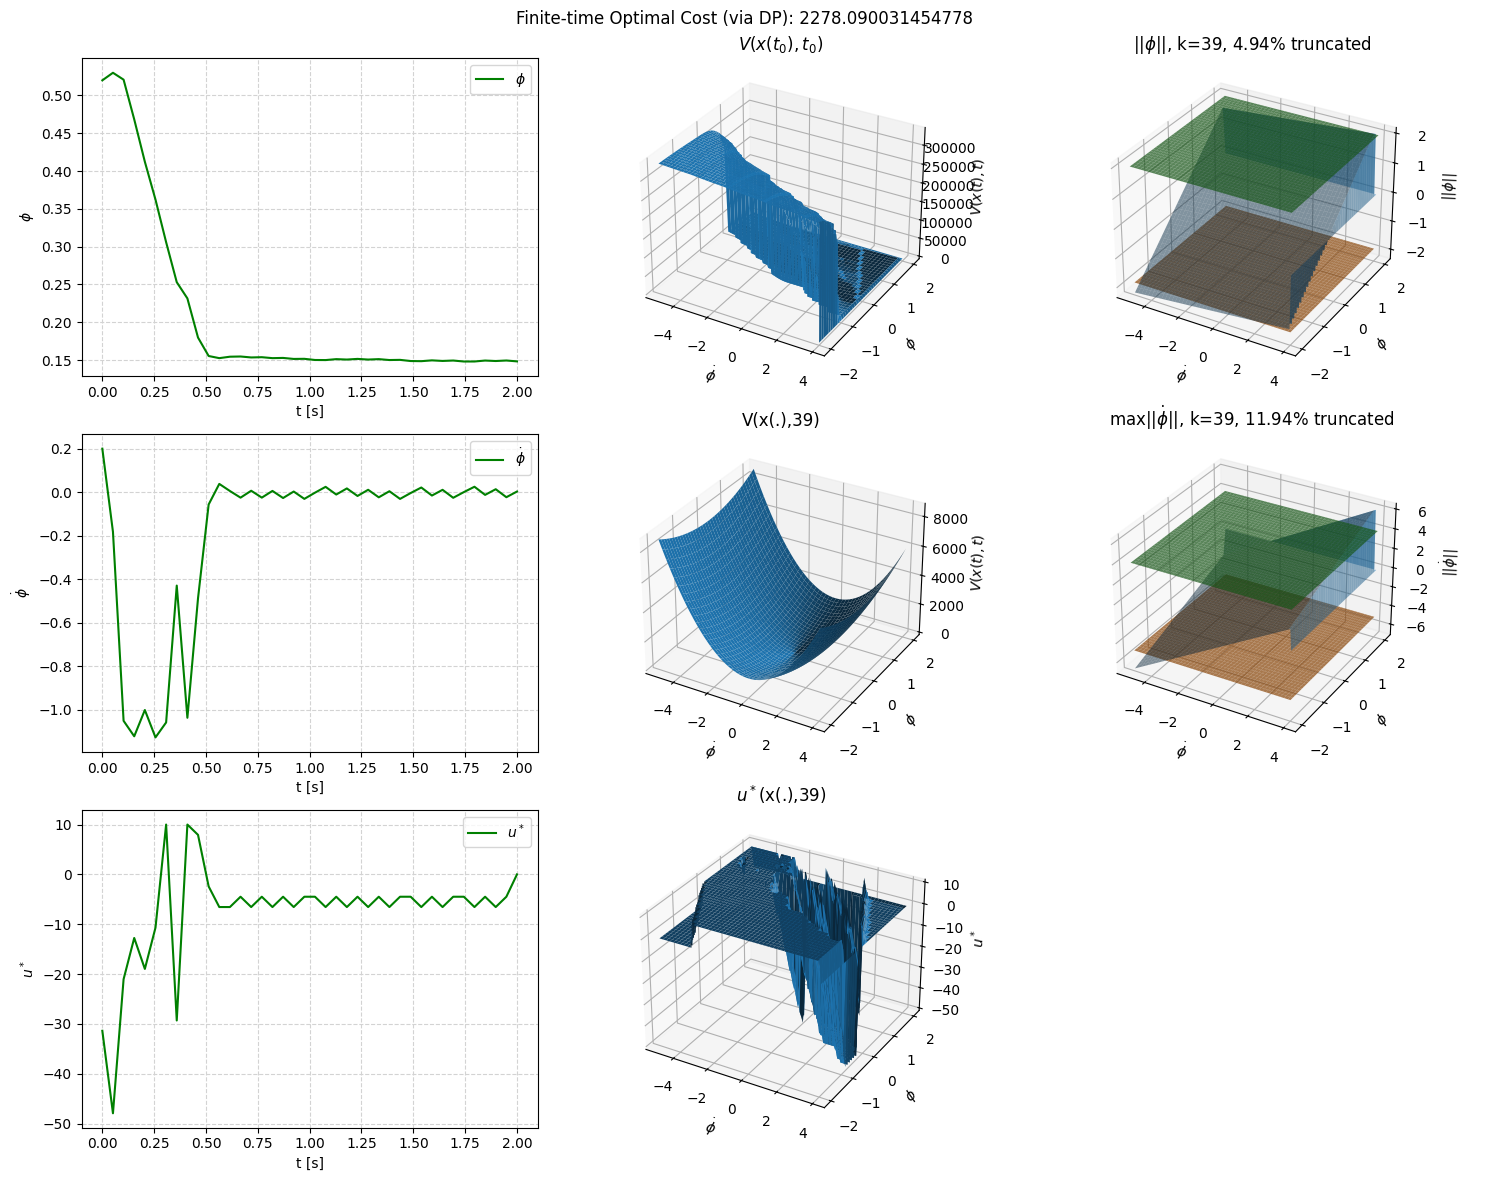

In [6]:
fig, ax = pt.subplots(3,3, figsize=(15,12))

Vx0 = V[lookup(Phidot[:,0],x0[1])[0], lookup(Phi[0,:],x0[0])[0], 0]
invalPhi = 100 * np.where(np.logical_or(errPhi[:,:] > Phi[1,-1], errPhi[:,:] < Phi[1,1]))[0].size \
    / (Phi[:,1].size * Phidot[1,:].size)
invalPhidot = 100 * np.where(np.logical_or(errPhidot[:,:] > Phidot[-1,1], errPhidot[:,:] < Phidot[1,1]))[0].size \
    / (Phi[:,1].size * Phidot[1,:].size)
           
ax[0,0].plot(T, x[:,0], 'g-', label=r'$\phi$')
ax[0,0].set(xlabel=r't [s]', ylabel=r'$\phi$')
ax[1,0].plot(T, x[:,1], 'g-', label=r'$\dot\phi$')
ax[1,0].set(xlabel=r't [s]', ylabel=r'$\dot\phi$')
ax[2,0].plot(T, u, 'g-', label=r'$u^*$')
ax[2,0].set(xlabel=r't [s]', ylabel=r'$u^*$')

ax1 = fig.add_subplot(3,3,2, projection='3d')
ax1.plot_surface(Phidot, Phi, V[:,:,1])
ax1.set(xlabel=r'$\dot\phi$', ylabel=r'$\phi$', zlabel=r'$V(x(t),t)$', title=r'$V(x(t_0),t_0)$')
ax1.plot(x0[1], x0[0], Vx0, marker='*')

kp = N-1
ax2 = fig.add_subplot(3,3,5, projection='3d')
ax2.plot_surface(Phidot, Phi, V[:,:,kp])
ax2.set(xlabel=r'$\dot\phi$', ylabel=r'$\phi$', zlabel=r'$V(x(t),t)$', title=f'V(x(.),{kp})')

ax3 = fig.add_subplot(3,3,8, projection='3d')
ax3.plot_surface(Phidot, Phi, u_opt[:,:,depth])
ax3.set(xlabel=r'$\dot\phi$', ylabel=r'$\phi$', zlabel=r'$u^*$', title=f'$u^*$(x(.),{kp})')

ax4 = fig.add_subplot(3,3,3, projection='3d')
ax4.plot_surface(Phidot, Phi, errPhi, alpha=.5, label=r'$||\phi||$')
ax4.set(xlabel=r'$\dot\phi$', ylabel=r'$\phi$', zlabel=r'$||\phi||$',
        title=f'$||\phi||$, k={kp}, {invalPhi:.2f}% truncated')
ax4.plot_surface(Phidot, Phi, np.ones((Phidot.shape[0], Phi.shape[1]))*Phi[1,1], alpha=.7)
ax4.plot_surface(Phidot, Phi, np.ones((Phidot.shape[0], Phi.shape[1]))*Phi[-1,-1], alpha=.7)

ax5 = fig.add_subplot(3,3,6, projection='3d')
ax5.plot_surface(Phidot, Phi, errPhidot, alpha=.5, label=r'$||\dot\phi||$')
ax5.set(xlabel=r'$\dot\phi$', ylabel=r'$\phi$', zlabel=r'$||\dot\phi||$',
        title=f'$\max||\dot\phi||$, k={kp}, {invalPhidot:.2f}% truncated')
ax5.plot_surface(Phidot, Phi, np.ones((Phidot.shape[0], Phi.shape[1]))*Phidot[1,1], alpha=.7)
ax5.plot_surface(Phidot, Phi, np.ones((Phidot.shape[0], Phi.shape[1]))*Phidot[-1,-1], alpha=.7)

for i in range(ax.shape[0]):
    ax[i,0].grid(color='lightgray', linestyle='--')
    ax[i,0].legend()
    ax[i,1].axis('off')
    ax[i,2].axis('off')
fig.suptitle(f'Finite-time Optimal Cost (via DP): {Vx0}')
pt.tight_layout()
pt.show()